# Roberto Puglisi - IBM Data Science Professional Certificate

# *Assignment: Segmenting and Clustering Neighborhoods in Toronto*

## I. Import libraries

In [1]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests
from bs4 import BeautifulSoup as bs4
import re
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import numpy as np
!pip install folium
import folium

     |████████████████████████████████| 93 kB 2.6 MB/s eta 0:00:011


## 1. Scraping data and creating Pandas DataFrame

### 1.1. Creating session

Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:

In [2]:
wikilink = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
session = requests.Session()
response = session.get(wikilink)

### 1.2. Scraping data

In [3]:
soup = bs4(response.text , 'html.parser') 

In [4]:
main_table = soup.select("table")[0] 
db = main_table.getText().replace('\n\n', '|').replace('\n', '\n|') #removing html code and formatting with '|' separator

Below I create an empty column, and the I append rows..

In [5]:
cig = []

splitted = db.split("\n") #splitting rows (separation on '\n')
for i in range(len(splitted)):
    separated = splitted[i].split("|")[1:4] #for each row it splits fields on '|'
    cig.append(separated)
    
cig = cig[:-1] #here I remove the last row as it was an empty list ['']

### 1.3. Passing the Table to pandas

..then I create a dataframe using the list above

In [6]:
df = pd.DataFrame(cig)
df = df.rename(columns=df.iloc[0]).drop([0]) #here I set column names from the first row

The DataFrame has the following Shape:

In [7]:
df.shape

(180, 3)

Below I apply the filter by removing rows where Borough is not assigned:

In [8]:
df = df[df['Borough'] != 'Not assigned'].reset_index(drop = True)
df.head(10)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [9]:
df.loc[df['Neighbourhood'] == 'Not assigned'] 

,Postal Code,Borough,Neighbourhood


After filtering the DataFrame has the following shape:

In [10]:
df.shape

(103, 3)

## 2. Retrieving geo-coordinates

In [11]:
coord_site = 'http://cocl.us/Geospatial_data'

In [12]:
coordb = pd.read_csv(coord_site)

In [13]:
coordf = pd.DataFrame(coordb)

Now I join the two dataframes:

In [14]:
df = pd.merge(df, coordf, on = 'Postal Code', how = 'left')
df.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [15]:
df.shape

(103, 5)

## 3. Data exploration and Clustering

I'll start by undestanding the composition of the Dataset, specifically the relationship between Boroughs and number of postal codes.

Let's create a new dataframe, counting the number of Postal Codes referring to each Boroughs in df: 

In [16]:
byborough = pd.pivot_table(df, index = ['Borough'], aggfunc = 'count', values = 'Postal Code').reset_index().set_index('Borough')
byborough

,Postal Code
Borough,
Central Toronto,9
Downtown Toronto,19
East Toronto,5
East York,5
Etobicoke,12
Mississauga,1
North York,24
Scarborough,17
West Toronto,6


In [17]:
print('There are ' + str(len(byborough.index)) + ' Boroughs in Toronto, and ' + str(len(df['Postal Code'].unique())) + ' Postal Codes.')

There are 10 Boroughs in Toronto, and 103 Postal Codes.


Now let's plot the data on a piechart:

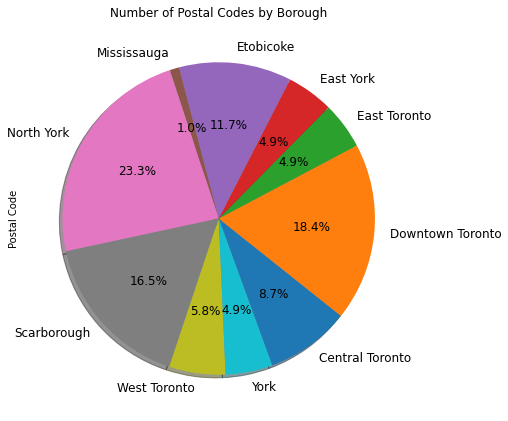

In [18]:
byborough.plot(y = 'Postal Code', kind = 'pie', figsize = (7, 30), fontsize = 12, legend = False, title = 'Number of Postal Codes by Borough', autopct='%1.1f%%', startangle=290, shadow = True)

In [19]:
byborough['% Post Codes'] = byborough['Postal Code']/byborough['Postal Code'].sum()
extr = byborough.sort_values(by = 'Postal Code', ascending = False)[0:4] #Firts 3 bt counts of postal codes
extr

,Postal Code,% Post Codes
Borough,,
North York,24,0.233010
Downtown Toronto,19,0.184466
Scarborough,17,0.165049
Etobicoke,12,0.116505


In [20]:
print('About ' + str(int(round(extr['% Post Codes'].sum(),2)*100)) + '% of the Total number of Postal codes in Toronto are whithin the first ' + str(len(extr['Postal Code'])) + ' Bouroughs, specifically: ' + str(list(extr.reset_index()['Borough'])).strip('[').strip(']') + '.')

About 70% of the Total number of Postal codes in Toronto are whithin the first 4 Bouroughs, specifically: 'North York', 'Downtown Toronto', 'Scarborough', 'Etobicoke'.


### Now let's create the Map of Toronto using Folium

The mean of coordinates will be the center of the map:

In [21]:
center = [df['Latitude'].mean(), df['Longitude'].mean()]
center 

[43.704607733980595, -79.3971529116505]

In [77]:
m = folium.Map(location= center, zoom_start=11)
# add markers to map
for lat, lng, bour, neigh in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(bour, neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(m)  

m

## Explore venues in Toronto using Forsquare API

Below I set up the Foursquare API and definine the parameters:

In [39]:
#definig the latitude and longitude using above dataframe
lat = df.loc[0, 'Latitude'] # neighborhood latitude value
lon = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighbourhood'] # neighborhood name
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, lat, lon))

CLIENT_ID = 'PVI10XZ5FMK0QMMD235S3TJAIGUP5L5L22W0METQYCMYZMMO' # your Foursquare ID
CLIENT_SECRET = 'D0SJYCFJLFD12FCWDVLHDIL5TWJU3PYGTNQPO40SXBCIVA3S' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100
radius =1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, lat,lon, radius, LIMIT)

# gettig the venues data form Forsquare API in json format
results = requests.get(url).json()
results

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


{'meta': {'code': 200, 'requestId': '5fa7398106eac44a5ff7bacf'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 28,
  'suggestedBounds': {'ne': {'lat': 43.762258609000014,
    'lng': -79.31721997969855},
   'sw': {'lat': 43.74425859099999, 'lng': -79.34209302030145}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b8991cbf964a520814232e3',
       'name': "Allwyn's Bakery",
       'location': {'address': '81 Underhill drive',
        'lat': 43.75984035203157,
        'lng': -79.32471879917513,
        'labeledLatLngs': [{'label': 'display'

In the json file the information related to venues are stored in: 'response' --> 'groups' -- > 'items'.
Below I create a pd DataFrame for venues data using the json_normalize function:

In [40]:
venues = results['response']['groups'][0]['items']
venues_df = pd.json_normalize(venues) # json_normalize(venues) 
venues_df.head(30)

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,...,venue.location.cc,venue.location.neighborhood,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet
0,e-0-4b8991cbf964a520814232e3-0,0,"[{'summary': 'This spot is popular', 'type': '...",4b8991cbf964a520814232e3,Allwyn's Bakery,81 Underhill drive,43.759840,-79.324719,"[{'label': 'display', 'lat': 43.75984035203157...",833,...,CA,Parkwoods - Donalda,Toronto,ON,Canada,"[81 Underhill drive, Toronto ON M3A 1Z5, Canada]","[{'id': '4bf58dd8d48988d144941735', 'name': 'C...",0,[],NaN
1,e-0-4e8d9dcdd5fbbbb6b3003c7b-1,0,"[{'summary': 'This spot is popular', 'type': '...",4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,Toronto,43.751976,-79.332140,"[{'label': 'display', 'lat': 43.75197604605557...",245,...,CA,NaN,Toronto,ON,Canada,"[Toronto, Toronto ON, Canada]","[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",0,[],NaN
2,e-0-57e286f2498e43d84d92d34a-2,0,"[{'summary': 'This spot is popular', 'type': '...",57e286f2498e43d84d92d34a,Tim Hortons,215 Brookbanks,43.760668,-79.326368,"[{'label': 'display', 'lat': 43.76066827030228...",866,...,CA,NaN,Toronto,ON,Canada,"[215 Brookbanks (York Miils Rd), Toronto ON M3...","[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",0,[],York Miils Rd
3,e-0-4bafa285f964a5203a123ce3-3,0,"[{'summary': 'This spot is popular', 'type': '...",4bafa285f964a5203a123ce3,Bruno's valu-mart,83 Underhill,43.746143,-79.324630,"[{'label': 'display', 'lat': 43.746143, 'lng':...",889,...,CA,NaN,Don Mills,ON,Canada,"[83 Underhill (at Donwood Plaza), Don Mills ON...","[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",0,[],at Donwood Plaza
4,e-0-58a8dcaa6119f47b9a94dc05-4,0,"[{'summary': 'This spot is popular', 'type': '...",58a8dcaa6119f47b9a94dc05,A&W,1277 York Mills Road,43.760643,-79.326865,"[{'label': 'display', 'lat': 43.76064307616131...",852,...,CA,NaN,Toronto,ON,Canada,"[1277 York Mills Road, Toronto ON M3A 1Z5, Can...","[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",0,[],NaN
5,e-0-4c422e48e26920a1a4ad5fe7-5,0,"[{'summary': 'This spot is popular', 'type': '...",4c422e48e26920a1a4ad5fe7,Shoppers Drug Mart,1277 York Mills Rd,43.760857,-79.324961,"[{'label': 'display', 'lat': 43.76085733239677...",926,...,CA,NaN,Toronto,ON,Canada,[1277 York Mills Rd (At Parkwoods Village Driv...,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",0,[],At Parkwoods Village Drive
6,e-0-4b26adc3f964a5205f7f24e3-6,0,"[{'summary': 'This spot is popular', 'type': '...",4b26adc3f964a5205f7f24e3,Food Basics,1277 York Mills Rd,43.760549,-79.326045,"[{'label': 'display', 'lat': 43.76054899113784...",861,...,CA,Parkwoods - Donalda,Toronto,ON,Canada,[1277 York Mills Rd (at Parkwoods Village Dr.)...,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",0,[],at Parkwoods Village Dr.
7,e-0-4fb699dd7bebbeb2a6c7badb-7,0,"[{'summary': 'This spot is popular', 'type': '...",4fb699dd7bebbeb2a6c7badb,Shoppers Drug Mart,51 Underhill Dr,43.745315,-79.325800,"[{'label': 'display', 'lat': 43.745315, 'lng':...",937,...,CA,NaN,North York,ON,Canada,"[51 Underhill Dr (at Donwood Plaza), North Yor...","[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",0,[],at Donwood Plaza
8,e-0-4b845f3ff964a520733131e3-8,0,"[{'summary': 'This spot is popular', 'type': '...",4b845f3ff964a520733131e3,High Street Fish & Chips,55 Underhill Dr.,43.745260,-79.324949,"[{'label': 'display', 'lat': 43.74525988387223...",967,...,CA,NaN,Toronto,ON,Canada,"[55 Underhill Dr. (at Donwood Plaza), Toronto ...","[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",0,[],at Donwood Plaza
9,e-0-4b5f7253f964a520d7ba29e3-9,0,"[{'summary': 'This spot is popular', 'type': '...",4b5f7253f964a520d7ba29e3,Pizza Pizza,"1277 York Mills Road, Unit 9",43.760231,-79.325666,"[{'label': 'display', 'lat': 43.76023098701761.

After analyzing the dataset, I create a new dataset which contains a subset of data (for my analysis the most interesting information is contained in this subset):

In [41]:
venues_df = venues_df[['venue.name', 'venue.categories', 'venue.location.postalCode', 'venue.location.lat', 'venue.location.lng']]

In [42]:
# to show whole text in columns in dataframe python: https://stackoverflow.com/a/25352191
pd.set_option("display.max_colwidth" , -1)
venues_df.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  from ipykernel import kernelapp as app


,venue.name,venue.categories,venue.location.postalCode,venue.location.lat,venue.location.lng
0,Allwyn's Bakery,"[{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}]",M3A 1Z5,43.759840,-79.324719
1,Brookbanks Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'Park', 'pluralName': 'Parks', 'shortName': 'Park', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_', 'suffix': '.png'}, 'primary': True}]",NaN,43.751976,-79.332140
2,Tim Hortons,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}]",M3A 1Z5,43.760668,-79.326368
3,Bruno's valu-mart,"[{'id': '4bf58dd8d48988d118951735', 'name': 'Grocery Store', 'pluralName': 'Grocery Stores', 'shortName': 'Grocery Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_', 'suffix': '.png'}, 'primary': True}]",M3A 2P5,43.746143,-79.324630
4,A&W,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_', 'suffix': '.png'}, 'primary': True}]",M3A 1Z5,43.760643,-79.326865


In [43]:
# reset set option dataframe: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.reset_option.html
pd.reset_option('display.max_colwidth')

The Column "categories" incorporates some code from the json, let's extract only the category name as set it as the new category value:

In [44]:
venues_df['venue.categories'] = venues_df.apply(lambda x: x['venue.categories'][0]['name'], axis=1)
venues_df.head(20)

,venue.name,venue.categories,venue.location.postalCode,venue.location.lat,venue.location.lng
0,Allwyn's Bakery,Caribbean Restaurant,M3A 1Z5,43.759840,-79.324719
1,Brookbanks Park,Park,NaN,43.751976,-79.332140
2,Tim Hortons,Café,M3A 1Z5,43.760668,-79.326368
3,Bruno's valu-mart,Grocery Store,M3A 2P5,43.746143,-79.324630
4,A&W,Fast Food Restaurant,M3A 1Z5,43.760643,-79.326865
5,Shoppers Drug Mart,Pharmacy,M3A 1Z5,43.760857,-79.324961
6,Food Basics,Supermarket,M3A 1Z5,43.760549,-79.326045
7,Shoppers Drug Mart,Pharmacy,M3A 2J8,43.745315,-79.325800
8,High Street Fish & Chips,Fish & Chips Shop,M3A 2J7,43.745260,-79.324949
9,Pizza Pizza,Pizza Place,M3A 1Z5,43.760231,-79.325666


Below I simply remove the "venue." part from each column

In [46]:
venues_df.columns = [col.split(".")[-1] for col in venues_df.columns]
venues_df.head()

,name,categories,postalCode,lat,lng
0,Allwyn's Bakery,Caribbean Restaurant,M3A 1Z5,43.759840,-79.324719
1,Brookbanks Park,Park,NaN,43.751976,-79.332140
2,Tim Hortons,Café,M3A 1Z5,43.760668,-79.326368
3,Bruno's valu-mart,Grocery Store,M3A 2P5,43.746143,-79.324630
4,A&W,Fast Food Restaurant,M3A 1Z5,43.760643,-79.326865


The function below will be used to retrieve relevant information for venues from Foursquare

In [30]:
def get_near_by_venues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [51]:
toronto_venues = get_near_by_venues(names=df['Neighbourhood'],latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

In [48]:
print(toronto_venues.shape)
toronto_venues.head()

(2139, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [50]:
print('{} different venues categories'.format(len(toronto_venues['Venue Category'].unique())))

273 different venues categories


### One Hot Encoding

In [53]:
dt = pd.get_dummies(toronto_venues[['Venue Category']], prefix= "", prefix_sep= " ")

dt['Neighbourhood'] = toronto_venues['Neighbourhood'] # add neighborhood column back to dataframe

fixed_columns = [dt.columns[-1]] + list(dt.columns[:-1]) # moving neighborhood column to the first column
dt = dt[fixed_columns]
print(dt.shape)
dt.head()

(2139, 274)


,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category:

In [56]:
dtg = dt.groupby('Neighbourhood').mean().reset_index()
print(dtg.shape)
dtg.head()

(96, 274)


,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The following code prints each neighborhood along with the top 5 most common venues

In [57]:
num_top_venues = 5

for hood in downtown_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = downtown_grouped[downtown_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    
    #first rows is not usefull it has only Neighbourhood and Neighbourhood-name, so drop this row
    temp = temp.iloc[1:]
    temp['freq'] = round(temp['freq'].astype(float),2)# converting into float type and # taking round values
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True) # sorting the dataframe by 'freq' in decreasing order
    print(temp.head(num_top_venues))
    print('\n')

----Agincourt----
                        venue  freq
0              Clothing Store   0.2
1              Breakfast Spot   0.2
2                      Lounge   0.2
3                Skating Rink   0.2
4   Latin American Restaurant   0.2


----Alderwood, Long Branch----
             venue  freq
0      Pizza Place  0.29
1              Gym  0.14
2   Sandwich Place  0.14
3              Pub  0.14
4      Coffee Shop  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
                venue  freq
0                Bank  0.10
1         Coffee Shop  0.10
2   Mobile Phone Shop  0.05
3               Diner  0.05
4         Gas Station  0.05


----Bayview Village----
                  venue  freq
0   Japanese Restaurant  0.25
1    Chinese Restaurant  0.25
2                  Bank  0.25
3                  Café  0.25
4     Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                 venue  freq
0          Coffee Shop  0.09
1       Sandwich Place  0.09
2   Italian Restaura

          venue  freq
0   Coffee Shop  0.08
1          Café  0.05
2           Gym  0.04
3    Restaurant  0.04
4         Hotel  0.04


----Rosedale----
                  venue  freq
0                  Park  0.50
1                 Trail  0.25
2            Playground  0.25
3     Accessories Store  0.00
4   Monument / Landmark  0.00


----Roselawn----
                              venue  freq
0                       Music Venue   0.5
1                            Garden   0.5
2                 Accessories Store   0.0
3         Middle Eastern Restaurant   0.0
4   Molecular Gastronomy Restaurant   0.0


----Rouge Hill, Port Union, Highland Creek----
                         venue  freq
0   Construction & Landscaping   0.5
1                          Bar   0.5
2            Accessories Store   0.0
3           Miscellaneous Shop   0.0
4          Moroccan Restaurant   0.0


----Runnymede, Swansea----
               venue  freq
0               Café  0.09
1        Coffee Shop  0.09
2   Sushi Restaur

### Let's put Top venues into a pandas dataframe¶

In [61]:
def return_most_common_venues(row, num_top_venues):
    row = row.iloc[1:]
    row_sorted = row.sort_values(ascending=False)
    
    return row_sorted.index.values[0:num_top_venues]

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} most popular venue type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th most popular venue type'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighbourhood'] = dtg['Neighbourhood']

for ind in np.arange(dtg.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(dtg.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Neighbourhood,1st most popular venue type,2nd most popular venue type,3rd most popular venue type,4th most popular venue type,5th most popular venue type,6th most popular venue type,7th most popular venue type,8th most popular venue type,9th most popular venue type,10th most popular venue type
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Clothing Store,Breakfast Spot,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Discount Store
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Gym,Sandwich Place,Coffee Shop,Pub,Dog Run,Dim Sum Restaurant,Diner,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Fried Chicken Joint,Chinese Restaurant,Bridal Shop,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Supermarket
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant,Locksmith,Liquor Store,Comfort Food Restaurant,Juice Bar,Butcher


### Clustering Neighbours

In [63]:
# I'm considering number of clusters as 5.
k = 5

X = downtown_grouped.drop('Neighbourhood', axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters = k, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=0)

In [68]:
# add clustering labels
venues_sorted['Cluster_Labels']=  kmeans.labels_

downtown_toronto_merged = df
# merge top venues_sorted with toronto_data
downtown_toronto_merged = downtown_toronto_merged.join(venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

downtown_toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,1st most popular venue type,2nd most popular venue type,3rd most popular venue type,4th most popular venue type,5th most popular venue type,6th most popular venue type,7th most popular venue type,8th most popular venue type,9th most popular venue type,10th most popular venue type,Cluster_Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store,0.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,Intersection,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,1.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Café,Farmers Market,Spa,Beer Store,1.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service,1.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Coffee Shop,Yoga Studio,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Restaurant,Café,Chinese Restaurant,Portuguese Restaurant,1.0


In [69]:
downtown_toronto_merged.dtypes 
#downtown_toronto_merged['Cluster_Labels'] = downtown_toronto_merged['Cluster_Labels'] + 1.0
downtown_toronto_merged['Cluster_Labels'].unique()

array([ 0.,  1., nan,  4.,  3.,  2.])

In [70]:
downtown_toronto_merged['Cluster_Labels'] = np.where(downtown_toronto_merged['Cluster_Labels'].isnull(),0,downtown_toronto_merged['Cluster_Labels'])

In [73]:
downtown_toronto_merged.loc[downtown_toronto_merged['4th most popular venue type'].isnull()]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,1st most popular venue type,2nd most popular venue type,3rd most popular venue type,4th most popular venue type,5th most popular venue type,6th most popular venue type,7th most popular venue type,8th most popular venue type,9th most popular venue type,10th most popular venue type,Cluster_Labels
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
52,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Let's see the result of clustering wiht K-mean on a Folium map:

In [89]:
# create map
map_clusterd = folium.Map(location=center, zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_toronto_merged['Latitude'], downtown_toronto_merged['Longitude'],
                                  downtown_toronto_merged['Neighbourhood'], downtown_toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.8).add_to(map_clusterd)
       
map_clusterd